this is for all the awards

1. synth timeseries - done
2. synth tpfs via convolution on subpixel - done
3. fit with gaussian only on the first frame - done
4. fit with zernikes only on the first frame
5. look at coherence


In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from scipy.signal import convolve2d
from skimage.transform import rescale
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

In [2]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
prf = eleanor.prf.make_prf_from_source(star)

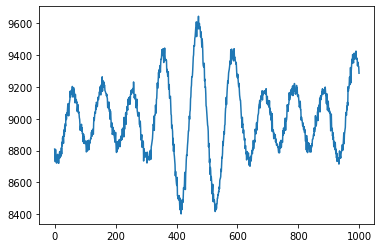

In [3]:
# make some synth data
# i want it to be a transit later so that I can get a CDPP
# but just for method validation let's use a sine wave
amps = 100 * np.array([1, 2, 3])
freqs = np.array([0.04, 0.05, 0.06])
phis = np.pi * np.array([1, 2, 3]) / 2
t = np.arange(0, 1000)
lc = 9000 + np.sum((a * np.sin(f * t + p) for a, f, p in zip(amps, freqs, phis)))
lc_m = lc + np.random.normal(0, 25, lc.shape)
plt.plot(t, lc_m)

In [4]:
xc, yc = 3.1, 6.8
base_tpf = np.zeros((99,99)) # 11x11 pixels times 9 subpixels
xl, xu = int(np.floor(xc * 9)), int(np.ceil(xc * 9)) 
yl, yu = int(np.floor(yc * 9)), int(np.ceil(yc * 9))
for (x, y) in [(xl, yl), (xu, yl), (xl, yu), (xu, yu)]:
    base_tpf[x, y] += (1 - abs(x - 9 * xc)) * (1 - abs(y - 9 * yc))
    
base_tpf = convolve2d(base_tpf, prf)[58:-58, 58:-58]
tpfs_up = np.array([base_tpf * f for f in lc_m])

In [5]:
tpfs = 160 + np.array([rescale(tpf_up.T, 1/9) for tpf_up in tpfs_up])
errs = 25 * np.ones_like(tpfs)

In [6]:
tpfs_t, errs_t = torch.tensor(tpfs), torch.tensor(errs)

In [7]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - tpfs_t[i]) ** 2, errs_t[i]))

In [9]:
model = eleanor.models.Gaussian(
            shape=tpfs.shape[1:], 
            col_ref=0, 
            row_ref=0, 
            xc = [xc],
            yc = [yc],
            bkg0 = 90,
            loss = nll
        )

nstars = 1
pars = model.get_default_par(tpfs[0])
num_psf_pars = len(model.get_default_optpars())
fout = np.zeros((len(tpfs), nstars))
bkgout = np.zeros(len(tpfs))
llout = np.zeros(len(tpfs))
parsout = np.zeros((len(tpfs), num_psf_pars))

def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = nll(mean_val, i)
    gradient = torch.autograd.grad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [10]:
for i in tqdm.trange(10):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x

print(res)

100%|██████████| 10/10 [00:00<00:00, 15.60it/s]     fun: array(1128.36929278)
     jac: array([ 6.53075968e-05,  1.25155812e-01, -1.64899145e-01, -2.46687896e-03,
        9.63287907e-02,  2.00001782e-02,  2.97518674e-01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 15
     nit: 4
  status: 1
 success: True
       x: array([ 7.96943578e+03, -4.36456501e-01, -5.06557315e-01,  1.65699062e+02,
        6.06761218e-01, -1.07707395e-02,  5.60743866e-01])



In [11]:
prf_pars = np.array([ 1.32345295e-01, -2.64309959e-03, -1.87840080e-03, -4.65669288e-02, 5.62057525e-03, -4.09518654e-03, -1.86680846e-04, 1.28241834e-03, 1.11773300e-04, 7.87455055e-04, 5.40537843e-03, 1.51009769e-03, -1.38667853e-03,  5.29446498e-04, -5.14992295e-04])

In [21]:
import eleanor
zmodel = eleanor.models.Zernike(
    shape=tpfs.shape[1:], 
    col_ref=0, 
    row_ref=0, 
    xc = [xc],
    yc = [yc],
    bkg0 = 90,
    loss = nll,
    source = star
)

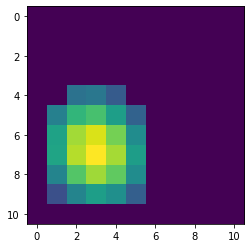

In [24]:
plt.imshow(zmodel(1, 3.0, 6.8, 3, prf_pars))

In [ ]:
p = torch.tensor(prf_pars, requires_grad=True)
%timeit torch.autograd.grad(torch.sum((zmodel(1, 3.0, 6.8, 1, p) - tpfs_t[0]) ** 2), p)

In [98]:
torch.sum((zmodel(1, 3.0, 6.8, 1, p) - tpfs_t[0]) ** 2)

tensor(11998689.0459, dtype=torch.float64, grad_fn=<SumBackward0>)

In [19]:
loss = lambda p: torch.sum((zmodel(1, 3.0, 6.8, 1, torch.tensor(p, requires_grad=True)) - tpfs_t[0]) ** 2).detach().numpy()
sopt.minimize(loss, x0=p.detach().numpy())

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)


NameError: name 'p' is not defined